### Table of Contents

1. [Preliminaries](#prlm)\
    1.1 [Import packages and data](#impt)\
    1.2 [Visualize the features](#featvis)\
    1.3

<a id='prlm'></a>
# 1. Preliminaries
<a id='impt'></a>
## 1.1 Import packages and data


In [87]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from scipy import stats
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [96]:
#import data
train_df=pd.read_csv('train.csv',index_col='PassengerId')
test_df=pd.read_csv('test.csv',index_col='PassengerId')

The labeled training data includes 891 passengers with the following 12 features:

In [97]:
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [98]:
#show data types
train_df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Numerical features: PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare.\
String features: Name, Sex, Ticket, Cabin, Embarked.

In [99]:
#Some statistics of each column.
train_df.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Leonard, Mr. Lionel",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<a id='featvis'></a>
## 1.2 Visualize the features
We will ignore the PassengerID feature because it very likely has no correlation to survival and we will also ignore Name, Cabin, and Ticket features because I do not have enough information to approach them analytically at this time.  This leaves us with categorical features Pclass, Sex, SibSp, Parch, and Embarked and numerical features Age and Fare. Let's plot the survival rate based on each of these features and determine if it looks like a useful feature.


We can define a function to plot the survived versus deceased rate for each categorical feature.

In [100]:
def survival_plot(df,col,x_vals,x_labels,plot_title,xaxis_title,yaxis_title):    
    df_= df.groupby([col,'Survived']).Name.agg('count').to_frame('Count').reset_index() #create count column by grouping
    df_ = pd.merge(df_,df_.groupby([col])[['Count']].sum(),how='inner',on=[col,]).rename(columns={'Count_x':'Count','Count_y':'Total'}) #add count column back 
    df_=pd.merge(pd.DataFrame({col:x_vals}).merge(pd.DataFrame({'Survived':[0,1]}),how='cross'),df_,how='left',on=[col,'Survived']) #define which x_vals to include (may be more or less than present)
    df_['Percent']=df_['Count']/df_['Total']*100  #add a percent column
    df_survived = df_[df_['Survived']==1].reset_index(drop=True)  #separate the survived and deceased
    df_deceased = df_[df_['Survived']==0].reset_index(drop=True)

    fig = go.Figure()
    fig.add_trace(go.Bar(name='Survived', x=x_labels, y=df_survived['Count'],
                        customdata=df_survived['Percent'],
                        hovertemplate='%{customdata:.2f}%',))
    fig.add_trace(go.Bar(name='Deceased', x=x_labels, y=df_deceased['Count'],
                        customdata=df_deceased['Percent'],
                        hovertemplate='%{customdata:.2f}%',))
    fig.update_layout(
        barmode='stack', 
        title=plot_title, 
        xaxis=dict(title=xaxis_title,titlefont_size=16,tickfont_size=14),
        yaxis=dict(title=yaxis_title,titlefont_size=16,tickfont_size=14)
    )
    fig.show()

### The Ticket Class (Pclass) feature
This feature represents the passenger's ticket class where 1= first class, 2= 2nd class, and 3= third class.  We observe the distribution in our training set.

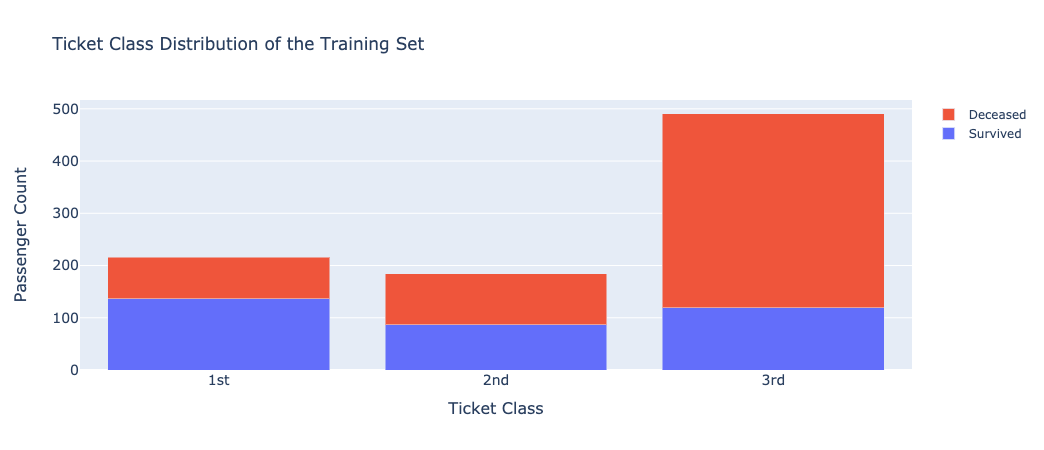

In [101]:
survival_plot(train_df,
                 col='Pclass',
                 x_vals=[1,2,3],
                 x_labels=['1st','2nd','3rd'],
                 plot_title='Ticket Class Distribution of the Training Set',
                 xaxis_title='Ticket Class',
                 yaxis_title='Passenger Count')

Ticket class seems to be a pretty decent indicator of survival.

### The Sex Feature
This feature indicates whether the passenger was male or female.  We suspect women will have a much higher survival rate.

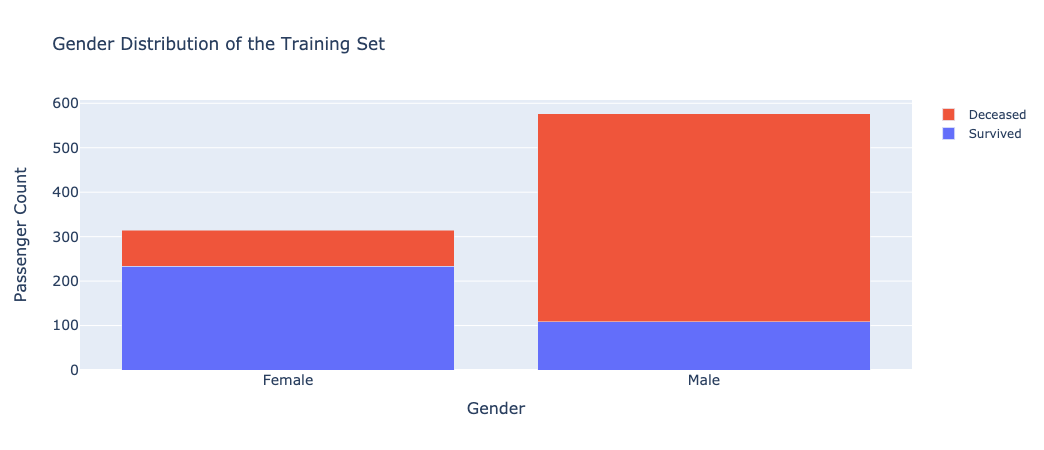

In [102]:
survival_plot(train_df,
                 col='Sex',
                 x_vals=['female','male'],
                 x_labels=['Female','Male'],
                 plot_title='Gender Distribution of the Training Set',
                 xaxis_title='Gender',
                 yaxis_title='Passenger Count')

The sex feature seems like a very good indicator of survival.

### The Sibling/Spouse (SibSp) Feature
This feature counts the number of siblings and/or spouses the passenger is onboard with.

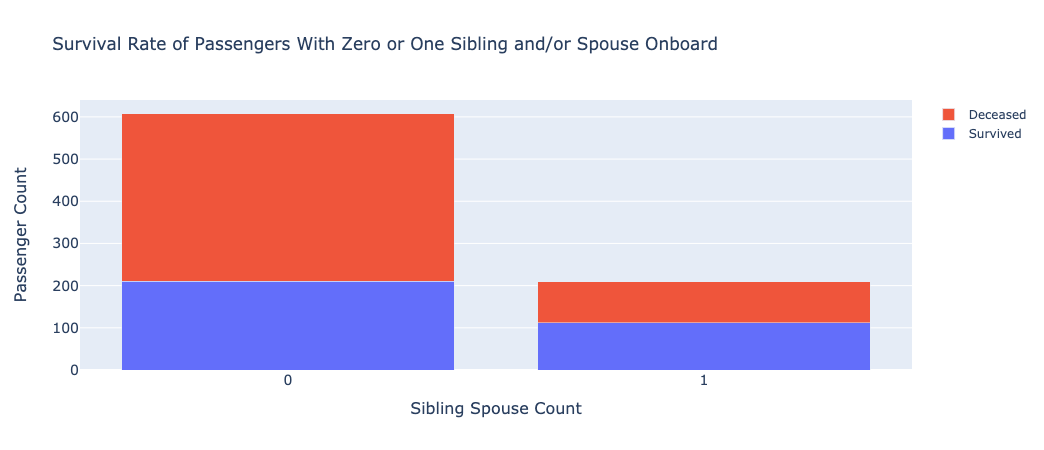

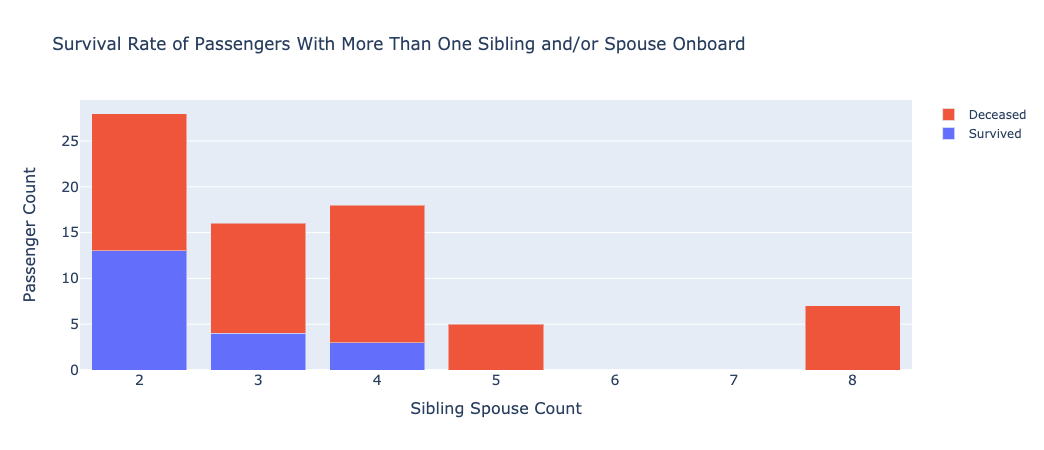

In [103]:
survival_plot(train_df,
                 col='SibSp',
                 x_vals=[0,1],
                 x_labels=['0','1'],
                 plot_title='Survival Rate of Passengers With Zero or One Sibling and/or Spouse Onboard',
                 xaxis_title='Sibling Spouse Count',
                 yaxis_title='Passenger Count')

survival_plot(train_df,
                 col='SibSp',
                 x_vals=[2,3,4,5,6,7,8],
                 x_labels=['2','3','4','5','6','7','8'],
                 plot_title='Survival Rate of Passengers With More Than One Sibling and/or Spouse Onboard',
                 xaxis_title='Sibling Spouse Count',
                 yaxis_title='Passenger Count')

In [104]:
print('Correlation coefficient: ',train_df['Survived'].corr(train_df['SibSp']))


Correlation coefficient:  -0.03532249888573559


This feature looks to be a poor indicator of surival, especially considering that most passengers only have a sibsp count of 0 or 1 where the survival rate is closest to 50%.

### The Parent/Child (Parch) Feature

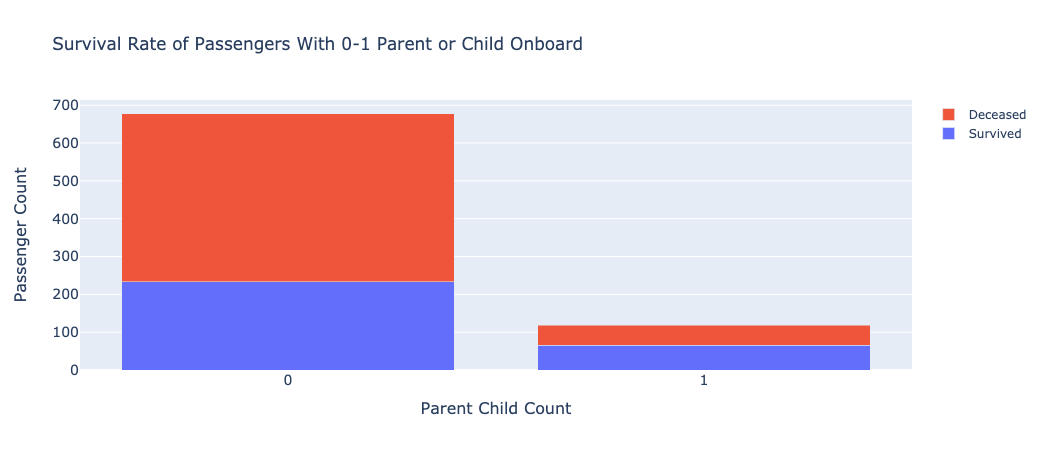

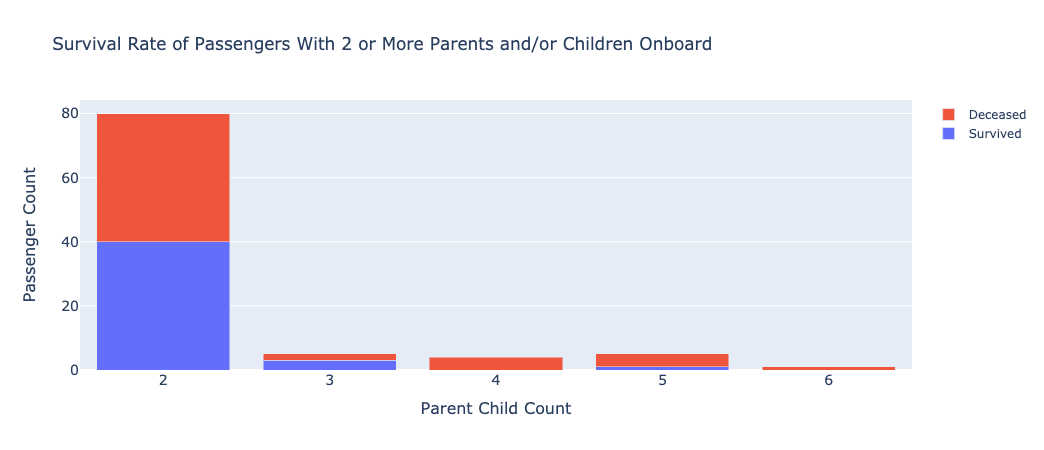

In [105]:
survival_plot(train_df,
                 col='Parch',
                 x_vals=[0,1],
                 x_labels=['0','1'],
                 plot_title='Survival Rate of Passengers With 0-1 Parent or Child Onboard',
                 xaxis_title='Parent Child Count',
                 yaxis_title='Passenger Count')

survival_plot(train_df,
                 col='Parch',
                 x_vals=[2,3,4,5,6],
                 x_labels=['2','3','4','5','6'],
                 plot_title='Survival Rate of Passengers With 2 or More Parents and/or Children Onboard',
                 xaxis_title='Parent Child Count',
                 yaxis_title='Passenger Count')

This features looks to be a poor indicator of survival.

In [106]:
print('Correlation coefficient: ',train_df['Survived'].corr(train_df['Parch']))

Correlation coefficient:  0.08162940708348365


### The Embarked Feature
This feature tells us what port the passenger embarked from, where C = Cherbourg, Q = Queenstown, S = Southampton.

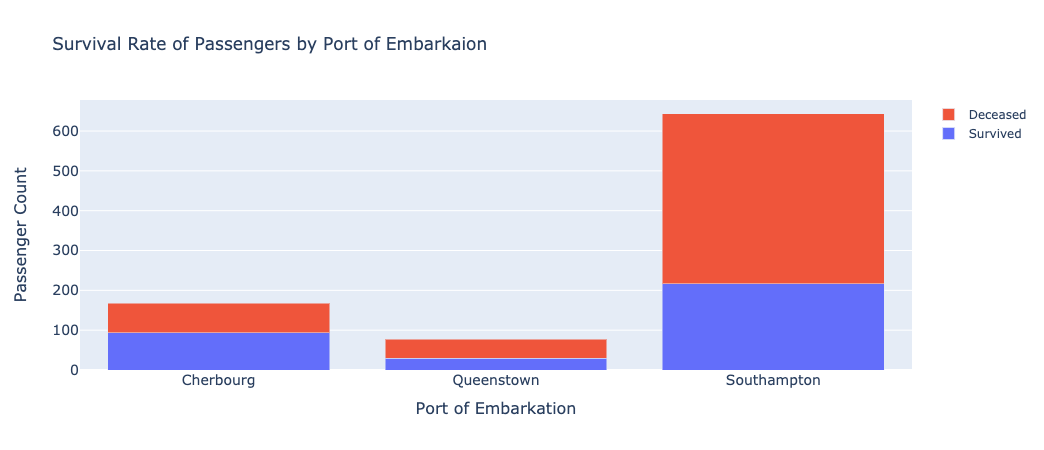

In [107]:
survival_plot(train_df,
                 col='Embarked',
                 x_vals=['C','Q','S'],
                 x_labels=['Cherbourg','Queenstown','Southampton'],
                 plot_title='Survival Rate of Passengers by Port of Embarkaion',
                 xaxis_title='Port of Embarkation',
                 yaxis_title='Passenger Count')

This feature also looks like a poor indicator of survival.

### The Age Feature
The age feature is fractional if less than 1 and the maximum age is 80.

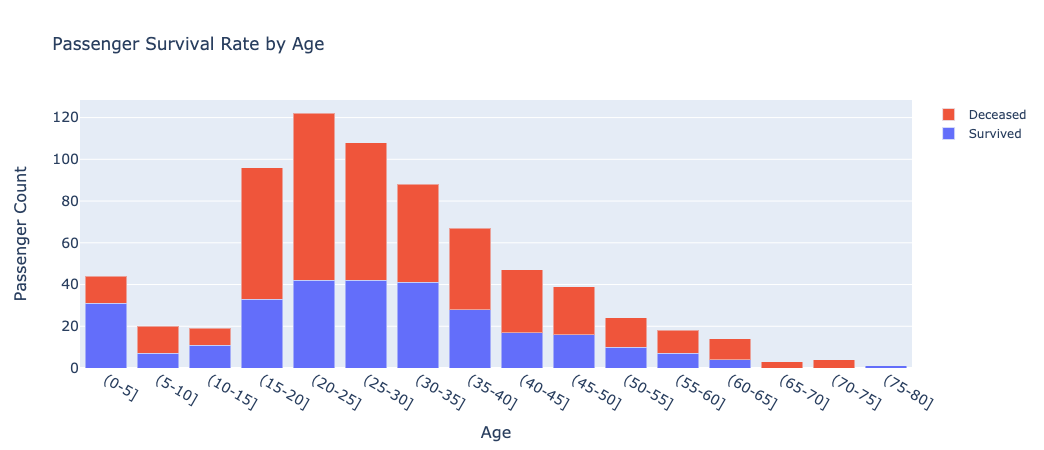

In [108]:
bins=np.linspace(0,80,17)
group_names=['({}-{}]'.format(int(bins[x]),int(bins[x+1])) for x in range(len(bins)-1)]
train_df['Age_cat']=pd.cut(train_df['Age'],bins,labels=group_names,include_lowest=True)

survival_plot(train_df,
                 col='Age_cat',
                 x_vals=group_names,
                 x_labels=group_names,
                 plot_title='Passenger Survival Rate by Age',
                 xaxis_title='Age',
                 yaxis_title='Passenger Count')

It seems like the only age range with a high likelihood of survival is 0-5 years.  Let's make a new binary feature called child which splits the passengers into adult and child.  We can find out exactly which age split will give us the best correlation to survival, since the choice of 0-5 years old above was arbitrary.

In [109]:
child_df=pd.DataFrame()
for x in range(1,18):    
    bins=[0,x,80]
    group_names=[0,1]
    train_df['Child']=pd.cut(train_df['Age'],bins,labels=group_names,include_lowest=True)
    c = train_df['Survived'].corr(train_df['Child'])
    child_df=child_df.append({'Age cut': x,'Corr coeff': c},ignore_index=True)
child_df.sort_values(by='Corr coeff',axis=0).T

,5,4,6,7,14,3,0,8,13,12,9,15,16,11,2,10,1
Age cut,6.000000,5.000000,7.000000,8.000000,15.000000,4.000000,1.000000,9.000000,14.000000,13.000000,10.000000,16.000000,17.000000,12.000000,3.000000,11.000000,2.000000
Corr coeff,-0.159972,-0.155697,-0.153007,-0.151725,-0.136028,-0.133354,-0.129864,-0.129812,-0.126191,-0.125435,-0.119854,-0.118196,-0.118011,-0.115579,-0.111087,-0.110567,-0.083103


So it appears that cutting the ages at 6 years gives us the best correlation coefficient.  We will now finalize this cut.

In [110]:
bins=[0,6,80]
group_names=[0,1]
train_df['Child']=pd.cut(train_df['Age'],bins,labels=group_names,include_lowest=True)
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Child
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,(20-25],1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,(35-40],1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,(25-30],1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,(30-35],1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,(30-35],1
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,NaN
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,(50-55],1
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,(0-5],0
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,(25-30],1


Now we have a new feature called Child.  We can try our classifier using Age and compare this to using Child.

### The Fare Feature
The fare listed seems a bit high for some passengers.  We notice that it's not fare per person, but fare of the total ticket which may include paying for multiple passengers.  When we sort the dataframe by the ticket number this is evident.

In [112]:
train_df[['Survived','Ticket','Fare']].sort_values(by='Ticket',axis=0).head(8)

,Survived,Ticket,Fare
PassengerId,,,
505,1,110152,86.50
258,1,110152,86.50
760,1,110152,86.50
263,0,110413,79.65
559,1,110413,79.65
586,1,110413,79.65
111,0,110465,52.00
476,0,110465,52.00


So now we can count how many passengers are on each ticket and adjust our fare column to represent fare per passenger rather than per ticket.  We see that the maximum fare goes from around 500 to around 200 dollars.

In [113]:
train_df_updated=train_df.join(train_df.groupby('Ticket')['Fare'].count(),on='Ticket', rsuffix=' count')
train_df_updated['Fare']=train_df_updated['Fare']/train_df_updated['Fare count']
train_df_updated.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Child,Fare count
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,(20-25],1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,(35-40],1,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,(25-30],1,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,26.5500,C123,S,(30-35],1,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,(30-35],1,1


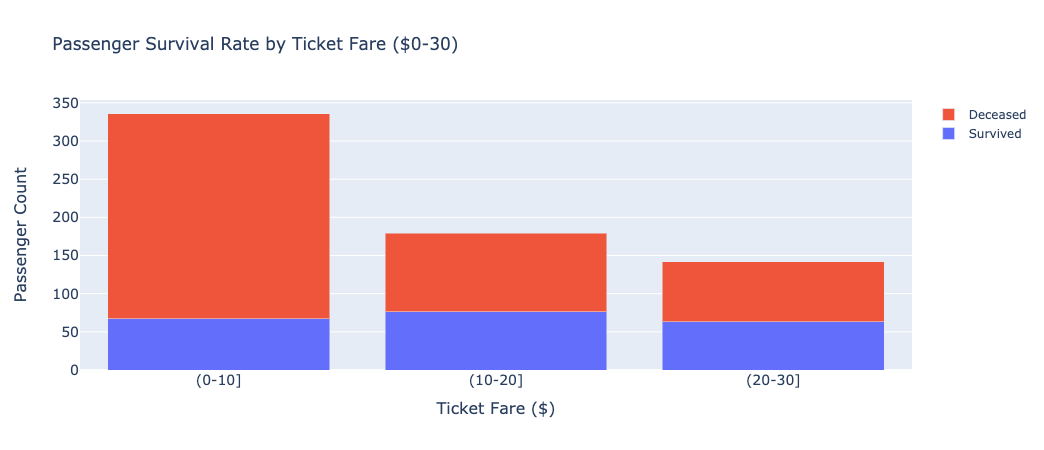

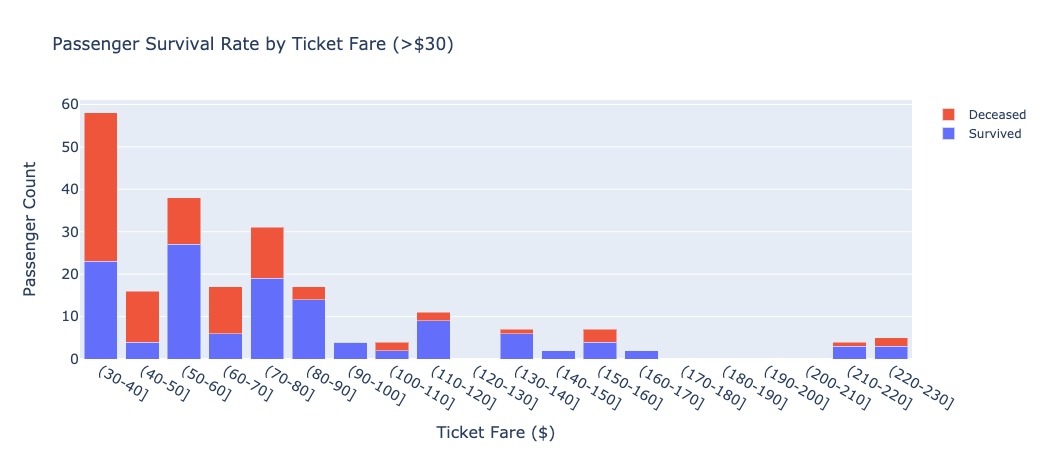

In [114]:
bins=np.linspace(0,230,24)
group_names=['({}-{}]'.format(int(bins[x]),int(bins[x+1])) for x in range(len(bins)-1)]
train_df_updated['Fare_cat']=pd.cut(train_df['Fare'],bins,labels=group_names,include_lowest=True)

survival_plot(train_df_updated,
                 col='Fare_cat',
                 x_vals=group_names[:3],
                 x_labels=group_names[:3],
                 plot_title='Passenger Survival Rate by Ticket Fare ($0-30)',
                 xaxis_title='Ticket Fare ($)',
                 yaxis_title='Passenger Count')

survival_plot(train_df_updated,
                 col='Fare_cat',
                 x_vals=group_names[3:],
                 x_labels=group_names[3:],
                 plot_title='Passenger Survival Rate by Ticket Fare (>$30)',
                 xaxis_title='Ticket Fare ($)',
                 yaxis_title='Passenger Count')

This feature looks to be a pretty good indicator of survival.

In [115]:
print('Correlation coefficient: ',train_df_updated['Survived'].corr(train_df_updated['Fare']))

Correlation coefficient:  0.254824108533421


### Visualization conclusions: 
So we've decided to include as features for our classifier: Pclass, Sex, Age, Child, and Fare.

## Missing Values in Training Data
We can see that we are missing 177 Age values. We aren't going to be using Cabin or Embarked values so we don't have to worry about those.

In [306]:
#import data
train_df=pd.read_csv('train.csv',index_col='PassengerId')
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Using the Name feature to infer age

The title of each passenger, as in Mr., Mrs, etc. may hold useful information about the passenger's age.  This can help us approximate the 177 unknown ages.  We will extract the title from each passenger's name, where we define a title as all text that comes before the first period followed by a space if there is one.

In [307]:
#Define a function to return title from a full name
def find_title(name):
    try:
        name_title = re.search('\s[a-zA-Z]+\.', name).group()
    except AttributeError:
        name_title = np.nan
    return name_title

#apply this function to each name creating a new title feature
train_df['Title']=train_df.apply(lambda x: find_title(x['Name']),axis=1)
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev.
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss.
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss.


Let's look at the age distribution associated with each name title.

In [308]:
age_df=train_df.groupby('Title')[['Age']].count().join(
            train_df.groupby('Title')[['Age']].mean().join(
                train_df.groupby('Title')[['Age']].std(), on='Title', lsuffix=' mean', rsuffix=' std'),on='Title').rename(columns={'Age':'Age Count'}).reset_index()

#Combine Miss and Ms. 
age_df.loc[14,'Age mean']=age_df.loc[9,'Age mean']

age_df

,Title,Age Count,Age mean,Age std
0,Capt.,1,70.000000,NaN
1,Col.,2,58.000000,2.828427
2,Countess.,1,33.000000,NaN
3,Don.,1,40.000000,NaN
4,Dr.,6,42.000000,12.016655
5,Jonkheer.,1,38.000000,NaN
6,Lady.,1,48.000000,NaN
7,Major.,2,48.500000,4.949747
8,Master.,36,4.574167,3.619872
9,Miss.,146,21.773973,12.990292


We will use these age averages to fill in the all the missing ages.

In [309]:
#Add the mean age by Title to each passenger with a missing age
train_df_final=train_df.merge(age_df[['Title','Age mean']], how='left', left_on="Title", right_on="Title")
train_df_final.loc[train_df_final.Age.isnull(),'Age']=train_df_final.loc[train_df_final.Age.isnull(),'Age mean']

#Update the Child feature based on the new inferred ages
bins=[0,6,80]
group_names=[0,1]
train_df_final['Child']=pd.cut(train_df_final['Age'],bins,labels=group_names,include_lowest=True)
train_df_final

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age mean,Child
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Mr.,32.368090,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs.,35.898148,1
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,21.773973,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs.,35.898148,1
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Mr.,32.368090,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,Rev.,43.166667,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Miss.,21.773973,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.773973,1,2,W./C. 6607,23.4500,NaN,S,Miss.,21.773973,1
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Mr.,32.368090,1


Let's double check that we have eliminated all missing values from the features we will train.

In [310]:
train_df_final=train_df_final[['Survived','Pclass','Age','Sex','Child']]
train_df_final.isnull().sum()

Survived    0
Pclass      0
Age         0
Sex         0
Child       0
dtype: int64

### Missing Values in Test Data

We also need to handle missing data in our test data so let's redo the same process.

In [311]:
#import test data
test_df=pd.read_csv('test.csv',index_col='PassengerId')
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [312]:
#Add title feature to test data
test_df['Title']=test_df.apply(lambda x: find_title(x['Name']),axis=1)

#Find stats by title on test data
test_age_df=test_df.groupby('Title')[['Age']].count().join(
                test_df.groupby('Title')[['Age']].mean().join(
                    test_df.groupby('Title')[['Age']].std(), on='Title', lsuffix=' mean', rsuffix=' std'),on='Title').rename(columns={'Age':'Age Count'}).reset_index()

#Combine Miss and Ms. 
test_age_df.loc[7,'Age mean']=test_age_df.loc[4,'Age mean']

#Add the mean age by Title to each passenger with a missing age in test data
test_df_final=test_df.merge(test_age_df[['Title','Age mean']], how='left', left_on="Title", right_on="Title")
test_df_final.loc[test_df_final.Age.isnull(),'Age']=test_df_final.loc[test_df_final.Age.isnull(),'Age mean']

#Update the Child feature based on the new inferred ages in test data
bins=[0,6,80]
group_names=[0,1]
test_df_final['Child']=pd.cut(test_df_final['Age'],bins,labels=group_names,include_lowest=True)
test_df_final.isnull().sum()


Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
Title         0
Age mean      0
Child         0
dtype: int64

We used the name titles to determine each passenger's age.  Notice that one passenger's fare price is missing.  Let's give it the average fare of their Pclass.  

In [298]:
test_df_final.loc[test_df_final.Fare.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age mean,Child
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr.,32.0,1


In [299]:
test_df_final.loc[test_df_final.Fare.isnull(),'Fare']=test_df_final.loc[test_df_final.Pclass==3,'Fare'].mean()
test_df_final.loc[152]

Pclass                       3
Name        Storey, Mr. Thomas
Sex                       male
Age                       60.5
SibSp                        0
Parch                        0
Ticket                    3701
Fare                 12.459678
Cabin                      NaN
Embarked                     S
Title                      Mr.
Age mean                  32.0
Child                        1
Name: 152, dtype: object

In [313]:
test_df_final=test_df_final[['Pclass','Age','Sex','Child']]
test_df_final.isnull().sum()

Pclass    0
Age       0
Sex       0
Child     0
dtype: int64

Now our test data is ready as well.

# Prepare the Data for Classification Modeling

We split our training data into train and test data so we can evaluate our model's accuracy.

In [314]:
train_set=train_df_final
test_set=test_df_final

#Make all columns lowercase
train_set.columns=[x.lower() for x in train_df_final.columns]
test_set.columns=[x.lower() for x in test_df_final.columns]

#split the feature and target sets
X_set = train_set[['pclass','age','sex','child']]
y_set = train_set['survived']

#make dummy columns for categorical values
for col in ['pclass','sex','child']:
    X_set=pd.concat([X_set,pd.get_dummies(X_set[col],prefix = col,dtype=int)],axis=1)
    del X_set[col]
    test_set=pd.concat([test_set,pd.get_dummies(test_set[col],prefix = col,dtype=int)],axis=1)
    del test_set[col]
    
#make sure dummy columns match for training and test set
df=pd.concat([X_set,test_set],axis=0)
X_set=df.iloc[:len(X_set)]
test_set=df.iloc[len(X_set):]


In [315]:
X_set.columns

Index(['age', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
       'child_0', 'child_1'],
      dtype='object')

In [316]:
test_set.columns

Index(['age', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
       'child_0', 'child_1'],
      dtype='object')

**Scale and fit the data**

In [ ]:
StandardScaler().fit_transform(test_set.values[:,:1])
StandardScaler().fit_transform(X_set.values[:,:1])

# Use cross validation and compare the models

In [330]:
#Define all the classification models to compare
# define models to test:
base_models = [("SVM",      SVC()),                                                               #Support Vector Machines
               ("kNN",      KNeighborsClassifier(n_neighbors = 3)),                               #KNeighborsClassifier
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),                       #Logistic Regression model
               ("DT_model", DecisionTreeClassifier(random_state=42)),                             #Decision tree model
               ("RF_model", RandomForestClassifier(random_state=42, n_jobs=-1))]                  #Random Forest model

In [331]:
#Partition data into 5 folds for cross validation
kfolds = 5 
split = StratifiedKFold(n_splits=kfolds,
                        shuffle=True, 
                        random_state=42)  

#Loop through all the classification models and output their scores
models_data = {'min_score':{},'max_score':{},'mean_score':{},'std_dev':{}}
for name, model in base_models:
    # get cross validation score for each model:
    cv_results = cross_val_score(model, 
                                 X_set, y_set, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    
    # output:
    #To find the average of all the accuracies.
    min_score = round(min(cv_results)*100, 4)
    models_data['min_score'][name] = min_score
     
    #To find the max accuracy of all the accuracies.
    max_score = round(max(cv_results)*100, 4)
    models_data['max_score'][name] = max_score
    
    #To find the min accuracy of all the accuracies.
    mean_score = round(np.mean(cv_results)*100, 4)
    models_data['mean_score'][name] = mean_score
    
    # let's find the standard deviation of the data to see degree of variance in the results obtained by our model.
    std_dev = round(np.std(cv_results), 4)
    models_data['std_dev'][name] = std_dev
    
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) ---> min: {min_score}, max: {max_score}")

SVM cross validation accuarcy score: 79.5706 +/- 0.0139 (std) ---> min: 78.0899, max: 82.1229
kNN cross validation accuarcy score: 79.2367 +/- 0.0147 (std) ---> min: 76.9663, max: 81.4607
LR_model cross validation accuarcy score: 80.0226 +/- 0.024 (std) ---> min: 76.4045, max: 83.1461
DT_model cross validation accuarcy score: 79.3453 +/- 0.0237 (std) ---> min: 76.4045, max: 82.6816
RF_model cross validation accuarcy score: 79.4589 +/- 0.0242 (std) ---> min: 75.2809, max: 82.0225


In [332]:
models_df = pd.DataFrame(models_data).sort_values(by='mean_score',ascending=False)
models_df

,min_score,max_score,mean_score,std_dev
LR_model,76.4045,83.1461,80.0226,0.0240
SVM,78.0899,82.1229,79.5706,0.0139
RF_model,75.2809,82.0225,79.4589,0.0242
DT_model,76.4045,82.6816,79.3453,0.0237
kNN,76.9663,81.4607,79.2367,0.0147


We see that the random forest classifier scored the best, so we will used this model.

In [333]:
base_models[1][1]

KNeighborsClassifier(n_neighbors=3)

In [334]:
Y_pred = base_models[1][1].fit(X_set, y_set).predict(test_set)

In [335]:
Y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [336]:
submission = pd.DataFrame({
        "PassengerId": test_df.index,
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)